In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord

In [2]:
# https://sites.google.com/usfca.edu/neuralens/publications/lens-candidates-storfer-et-al-2022
huang20 = pd.read_csv('/home/walml/repos/galaxy-datasets/data/external_data/neuralens/candidates_H20.csv')
huang21 = pd.read_csv('/home/walml/repos/galaxy-datasets/data/external_data/neuralens/candidates_H21.csv')
storfer22 = pd.read_csv('/home/walml/repos/galaxy-datasets/data/external_data/neuralens/storfer22_full.csv')

In [3]:
huang20.columns.values

array(['Unnamed: 0', 'Index', 'Image', 'Name', 'Probability', 'Spec',
       'Photo-z', 'Ref', 'g mag', 'r mag', 'z mag'], dtype=object)

Tidy up the columns

In [4]:
huang20_renamer = {
    'Name': 'name', 'Probability': 'probability', 'Spec': 'spec_z', 'Photo-z': 'phot_z', 'g mag': 'mag_g', 'r mag': 'mag_r', 'z mag': 'mag_z',
}

huang20 = huang20.rename(columns=huang20_renamer)
huang20 = huang20[huang20_renamer.values()]
huang20

,name,probability,spec_z,phot_z,mag_g,mag_r,mag_z
0,DESI-011.5084-01.9412,0.94,0.5501,NaN,20.94,19.19,17.97
1,DESI-015.8164+00.0823,1.00,0.2662,NaN,19.64,18.08,17.21
2,DESI-016.3319+01.7490,0.99,0.3612,NaN,19.95,18.17,17.27
3,DESI-016.5230+00.5463,1.00,0.5941,NaN,21.52,19.66,18.25
4,DESI-018.1074+02.3773,0.95,0.5039,NaN,21.27,19.35,18.12
...,...,...,...,...,...,...,...
337,DESI-351.3891-12.0013,1.00,NaN,0.396+/-0.05,20.74,19.38,18.59
338,DESI-351.4008-11.9943,1.00,NaN,0.382+/-0.01,21.19,19.36,18.44
339,DESI-351.4290-12.2431,1.00,NaN,0.376+/-0.01,20.59,18.78,17.88
340,DESI-351.4915-11.6013,1.00,NaN,0.28+/-0.03,20.47,19.17,18.41


In [5]:
huang21_renamer = huang20_renamer.copy()
huang21_renamer.update({'Score': 'score', 'Score Diff': 'score_diff'})
huang21 = huang21.rename(columns=huang21_renamer)

In [6]:
huang21 = huang21[huang21_renamer.values()]

In [7]:
# storfer doesn't need renaming, only subset

storfer22 = storfer22.rename(columns={'phot-z': 'phot_z', 'spec-z': 'spec_z'})

storfer22 = storfer22[['name', 'ra', 'dec', 'grade', 'probability', 'spec_z', 'phot_z', 'mag_g', 'mag_r', 'mag_z']]
storfer22

,name,ra,dec,grade,probability,spec_z,phot_z,mag_g,mag_r,mag_z
0,DESI-000.7487-62.6672,0.748677,-62.667184,A,0.86,NaN,0.452±0.029,20.78,19.10,18.07
1,DESI-002.0671-32.6207,2.067074,-32.620688,A,1.00,NaN,0.260±0.021,18.57,17.15,16.37
2,DESI-003.7407+01.6170,3.740665,1.616990,A,1.00,NaN,0.336±0.051,20.04,18.79,17.92
3,DESI-007.0497-48.4352,7.049748,-48.435193,A,0.95,NaN,0.382±0.010,18.98,17.15,16.27
4,DESI-008.6210-45.8601,8.620970,-45.860087,A,0.97,NaN,0.525±0.016,20.46,18.52,17.32
...,...,...,...,...,...,...,...,...,...,...
3755,DESI-358.9749+01.4608,358.974942,1.460780,D,0.85,NaN,0.768±0.050,21.21,20.50,19.60
3756,DESI-359.0710+02.3037,359.070976,2.303690,D,0.87,NaN,0.578±0.072,21.61,20.21,19.11
3757,DESI-359.6156-37.8948,359.615564,-37.894784,D,0.52,NaN,0.635±0.059,20.90,19.73,18.67
3758,DESI-359.7982-00.1966,359.798171,-0.196566,D,0.64,0.7012,NaN,22.46,20.52,18.88


Huang 20 and Huang 21 don't include RA/Dec cols, so parse these out from the DESI names

In [8]:
# def desi_name_to_coords(name):
#     ra_str = name[5:13]  # DESI- prefix always, RA is 0 to 360
#     dec_str = name[13:]  # sometimes -, sometimes+, Dec is -90 to +90
#     # print(ra_str, dec_str)
#     return SkyCoord(ra=ra_str, dec=dec_str, frame='icrs', unit='deg')

# desi_name_to_coords('DESI-351.4891-00.8741')


def desi_names_to_coords(names: pd.Series):
    # parse RA/Dec from DESI name
    ra_strs = names.apply(lambda x: x[5:13]).values  # DESI- prefix always, RA is 0 to 360
    dec_strs = names.apply(lambda x: x[13:]).values # sometimes -, sometimes+, Dec is -90 to +90
    skycoord = SkyCoord(ra=ra_strs, dec=dec_strs, frame='icrs', unit='deg')
    return skycoord.ra.deg, skycoord.dec.deg

huang20_ra, huang20_dec = desi_names_to_coords(huang20['name'])
huang20['ra'] = huang20_ra
huang20['dec'] = huang20_dec

huang21_ra, huang21_dec = desi_names_to_coords(huang21['name'])
huang21['ra'] = huang21_ra
huang21['dec'] = huang21_dec

### Labels: grades, scores, oh my

Huang 20 doesn't have explicit grades listed on the sheet, but:

"[In the three tables below](https://sites.google.com/usfca.edu/neuralens/publications/lens-candidates-huang-et-al-2020), the 342 candidate systems from Huang et al. 2020 are grouped by Grade, each Grade is arranged in ascending RA."

So let's encode that ourselves.

In [9]:
huang20_grades = ['A'] * 60 + ['B'] * 106 + ['C'] * 176
huang20['grade'] = huang20_grades

Huang 21 uses scores, from 2 to 4 apparently.
<!-- https://arxiv.org/pdf/2005.04730.pdf -->

"
Co-authors S.B., A.G.,
A.P., V.R., C.S., W.S., and R.V. make the “first pass” selections, according to these criteria, erring
on the generous side

For the “second
pass”, co-authors X.H. and A.D. examine all “first pass” selections and assign an integer score
between 1 and 4. These two scores are averaged. We assign a letter grade according to the average,
using the following criteria.

≥ 3.5: Grade A. We have a high level of confidence of these candidates...

= 3.0: Grade B. They have similar characteristics as the Grade A’s. For the cutout images
where there appear to be giant arcs they tend to be fainter than those for the Grade A’s.

= 2.5 or 2.0: Grade C. They generally have features that are even fainter and/or smaller than
what is typical for Grade B candidates, but that are nevertheless suggestive of lensed arclets.
Counter images are often not present or indiscernible.
"

In [10]:
huang21['score'].value_counts()

score
2.0    510
2.5    387
3.0    199
3.5    116
4.0    100
Name: count, dtype: int64

Storfer returns to the same grade system as Huang20, but adds a D grade (not described in the paper, but presumably unlikely or rejected lenses)

In [11]:
storfer22['grade'].value_counts()

grade
D    1865
C    1254
B     526
A     115
Name: count, dtype: int64

Only H21 uses score/score delta, so let's simplify and stick with the grade system.

In [12]:
def score_to_grade(score):
    if score >= 3.5:
        return 'A'
    elif score >= 3.0:
        return 'B'
    else: 
        return 'C'

huang21['grade'] = huang21['score'].apply(score_to_grade)

In [13]:
huang20['grade'].value_counts(normalize=True).sort_index()

grade
A    0.175439
B    0.309942
C    0.514620
Name: proportion, dtype: float64

In [14]:
huang21['grade'].value_counts(normalize=True).sort_index()

grade
A    0.164634
B    0.151677
C    0.683689
Name: proportion, dtype: float64

In [15]:
# storfer22['grade'].value_counts(normalize=True).sort_index()

"Grade D systems are not counted as candidates in this paper, but we have
included them on our project website (URL provided in §4.2)."

In [16]:
storfer22 = storfer22[storfer22['grade'] != 'D']
storfer22['grade'].value_counts(normalize=True).sort_index()
# storfer has far fewer grade A's than H20 and H21, and H20 has more B vs C than H21 and storfer. Unclear if rating inconsistency or due to previous mining.

grade
A    0.060686
B    0.277573
C    0.661741
Name: proportion, dtype: float64

### Join the candidate lists

In [17]:
huang20.head()

,name,probability,spec_z,phot_z,mag_g,mag_r,mag_z,ra,dec,grade
0,DESI-011.5084-01.9412,0.94,0.5501,NaN,20.94,19.19,17.97,11.5084,-1.9412,A
1,DESI-015.8164+00.0823,1.00,0.2662,NaN,19.64,18.08,17.21,15.8164,0.0823,A
2,DESI-016.3319+01.7490,0.99,0.3612,NaN,19.95,18.17,17.27,16.3319,1.7490,A
3,DESI-016.5230+00.5463,1.00,0.5941,NaN,21.52,19.66,18.25,16.5230,0.5463,A
4,DESI-018.1074+02.3773,0.95,0.5039,NaN,21.27,19.35,18.12,18.1074,2.3773,A


In [18]:
huang21.head()

,name,probability,spec_z,phot_z,mag_g,mag_r,mag_z,score,score_diff,ra,dec,grade
0,DESI-002.0299+18.3723,0.97,0.4724,NaN,20.63,19.16,17.84,3.5,1,2.0299,18.3723,A
1,DESI-003.6745-13.5042,0.34,NaN,0.406+/-0.021,20.00,18.17,17.18,4.0,0,3.6745,-13.5042,A
2,DESI-006.0673-28.7195,0.97,NaN,0.533+/-0.025,20.80,18.86,17.55,4.0,0,6.0673,-28.7195,A
3,DESI-007.6741-33.9765,0.20,NaN,0.858+/-0.041,21.64,20.85,19.61,3.5,1,7.6741,-33.9765,A
4,DESI-007.8631-01.7215,0.53,0.5201,NaN,21.61,19.79,18.60,4.0,0,7.8631,-1.7215,A


In [19]:
storfer22.head()

,name,ra,dec,grade,probability,spec_z,phot_z,mag_g,mag_r,mag_z
0,DESI-000.7487-62.6672,0.748677,-62.667184,A,0.86,NaN,0.452±0.029,20.78,19.10,18.07
1,DESI-002.0671-32.6207,2.067074,-32.620688,A,1.00,NaN,0.260±0.021,18.57,17.15,16.37
2,DESI-003.7407+01.6170,3.740665,1.616990,A,1.00,NaN,0.336±0.051,20.04,18.79,17.92
3,DESI-007.0497-48.4352,7.049748,-48.435193,A,0.95,NaN,0.382±0.010,18.98,17.15,16.27
4,DESI-008.6210-45.8601,8.620970,-45.860087,A,0.97,NaN,0.525±0.016,20.46,18.52,17.32


In [20]:
huang20['label_origin'] = 'huang20'
huang21['label_origin'] = 'huang21'
storfer22['label_origin'] = 'storfer22'

df = pd.concat([huang20, huang21, storfer22], axis=0)
del df['score']
del df['score_diff']

df['phot_z_mean'] = df['phot_z'].apply(lambda x: float(x.split('+')[0].split('±')[0]) if type(x) == str else np.nan)

def get_best_z(galaxy):
    if not pd.isna(galaxy['spec_z']):
        return galaxy['spec_z']
    return galaxy['phot_z_mean']

df['best_z'] = df.apply(get_best_z, axis=1)

df.sample(10)

/tmp/ipykernel_12826/564266542.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storfer22['label_origin'] = 'storfer22'


,name,probability,spec_z,phot_z,mag_g,mag_r,mag_z,ra,dec,grade,label_origin,phot_z_mean,best_z
100,DESI-107.5775+40.1752,1.00,0.2928,NaN,19.20,17.62,16.74,107.577500,40.175200,A,huang21,NaN,0.2928
1158,DESI-054.7535-33.5287,0.90,NaN,0.727±0.058,21.66,20.74,19.73,54.753533,-33.528670,C,storfer22,0.727,0.7270
0,DESI-002.0299+18.3723,0.97,0.4724,NaN,20.63,19.16,17.84,2.029900,18.372300,A,huang21,NaN,0.4724
247,DESI-036.4827-16.8621,0.98,NaN,0.325+/-0.02,19.41,17.99,17.14,36.482700,-16.862100,C,huang20,0.325,0.3250
763,DESI-056.6788-09.2313,0.99,NaN,0.427+/-0.021,20.17,18.31,17.27,56.678800,-9.231300,C,huang21,0.427,0.4270
292,DESI-044.8581-52.1120,1.00,NaN,0.468±0.083,19.85,17.93,16.78,44.858141,-52.111958,B,storfer22,0.468,0.4680
226,DESI-029.5420-36.3009,0.98,NaN,0.607±0.070,21.24,20.25,19.46,29.541976,-36.300869,B,storfer22,0.607,0.6070
413,DESI-357.3718-60.0110,0.14,NaN,0.370+/-0.069,20.24,19.07,18.39,357.371800,-60.011000,B,huang21,0.370,0.3700
31,DESI-027.9088-04.1209,0.81,0.6412,NaN,21.89,20.11,18.58,27.908800,-4.120900,A,huang21,NaN,0.6412
1155,DESI-233.2341+50.1953,0.97,0.5655,NaN,20.16,18.71,17.37,233.234100,50.195300,C,huang21,NaN,0.5655


In [21]:
df['phot_z']

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
1890    0.613±0.012
1891    0.647±0.049
1892    0.818±0.047
1893    0.576±0.066
1894    0.809±0.067
Name: phot_z, Length: 3549, dtype: object

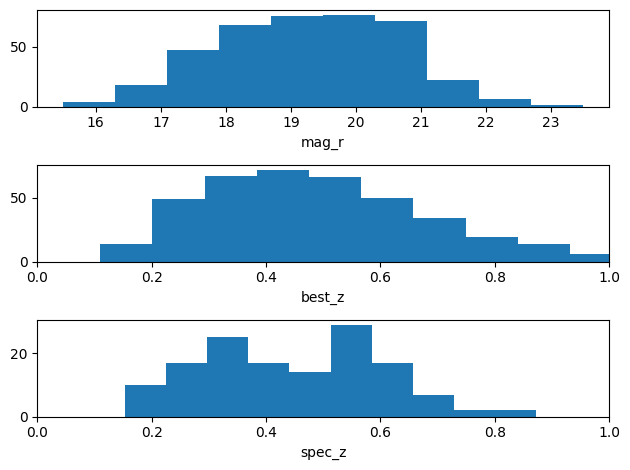

In [22]:
fig, axes = plt.subplots(nrows=3)

# df_to_show = df
# bins = 30

bins = 10
df_to_show = df.query('grade == "A"')

ax = axes[0]
ax.hist(df_to_show['mag_r'], bins=bins)
ax.set_xlabel('mag_r')


ax = axes[1]
ax.hist(df_to_show['best_z'], bins=bins)
ax.set_xlabel('best_z')
ax.set_xlim([0., 1.])

ax = axes[2]
ax.hist(df_to_show['spec_z'], bins=bins)
ax.set_xlabel('spec_z')
ax.set_xlim([0., 1.])

fig.tight_layout()

In [ ]:
df.to_csv('/home/walml/repos/galaxy-datasets/data/external_data/neuralens/neuralens_combined.csv', index=False)

In [32]:
# crossmatch to DESI LS DR8, to my images
mine = pd.read_parquet('/home/walml/repos/decals-rings/data/master_all_file_index_passes_file_checks.parquet', columns=['ra', 'dec', 'mag_r', 'mag_z', 'shapedev_r', 'shapeexp_r', 'fracdev'])

from shared_astro_utils import matching_utils
matched, unmatched = matching_utils.match_galaxies_to_catalog_pandas(df, mine, galaxy_suffix='_dr8', catalog_suffix='')
len(df), len(matched), len(unmatched)

(3549, 1108, 2441)

In [33]:
matched['grade'].value_counts().sort_index()

grade
A    210
B    294
C    604
Name: count, dtype: int64

In [35]:
matched

,name,probability,spec_z,phot_z,mag_g,mag_r_dr8,mag_z_dr8,ra_dr8,dec_dr8,grade,...,best_z,best_match,sky_separation,ra,dec,mag_r,mag_z,shapedev_r,shapeexp_r,fracdev
0,DESI-015.8164+00.0823,1.00,0.2662,NaN,19.64,18.08,17.21,15.816400,0.082300,A,...,0.2662,2316572,0.102533,15.816373,0.082291,18.081654,17.223543,1.917877,0.000000,1.000000
1,DESI-016.3319+01.7490,0.99,0.3612,NaN,19.95,18.17,17.27,16.331900,1.749000,A,...,0.3612,2514610,0.141972,16.331865,1.749018,18.235331,17.321905,2.796175,0.000000,1.000000
2,DESI-024.1631+00.1384,1.00,0.3441,NaN,18.83,17.18,16.29,24.163100,0.138400,A,...,0.3441,2344809,0.215491,24.163136,0.138352,17.238659,16.349171,13.624000,1.562426,0.743301
3,DESI-031.1712-15.0266,1.00,NaN,0.358+/-0.01,20.08,18.35,17.40,31.171200,-15.026600,A,...,0.3580,1074316,0.077616,31.171221,-15.026606,18.288408,17.362419,2.701432,0.000000,1.000000
4,DESI-038.2078-03.3906,1.00,NaN,0.416+/-0.04,20.08,18.39,17.40,38.207800,-3.390600,A,...,0.4160,1932007,0.159022,38.207761,-3.390579,18.368626,17.393044,2.768362,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,DESI-350.9765-14.6225,0.47,NaN,0.944±0.060,24.26,22.07,19.94,350.976800,-14.623100,C,...,0.9440,1098914,0.240524,350.976731,-14.623107,18.170486,17.201920,3.110677,0.000000,1.000000
1104,DESI-353.8567-64.4914,0.40,NaN,0.409±0.029,21.26,19.42,18.51,353.860300,-64.491700,C,...,0.4090,2278430,7.700871,353.856388,-64.490382,17.855278,16.905203,5.782764,0.000000,1.000000
1105,DESI-353.8879-40.8125,0.96,NaN,0.320±0.009,19.55,17.94,17.12,353.887901,-40.812510,C,...,0.3200,185329,0.009535,353.887899,-40.812512,18.222635,17.363792,2.178762,0.000000,1.000000
1106,DESI-354.5570+01.4542,0.44,NaN,0.231±0.043,19.20,18.67,18.34,354.557045,1.454179,C,...,0.2310,2511769,0.009592,354.557044,1.454182,18.670618,18.336617,0.000000,1.293242,0.000000


In [29]:
# TODO crossmatch to DR9 for Stein's images?
stein = pd.read_parquet('/home/walml/repos/zoobot-foundation/foundation/datasets/stein/latest_stein_catalog.parquet', columns=['ra', 'dec', 'brickid', 'objid'])

from shared_astro_utils import matching_utils
matched, unmatched = matching_utils.match_galaxies_to_catalog_pandas(df, stein, galaxy_suffix='_dr8', catalog_suffix='')
len(df), len(matched), len(unmatched)

(3549, 1457, 2092)

In [31]:
matched['grade'].value_counts().sort_index()

grade
A    231
B    376
C    850
Name: count, dtype: int64

In [25]:
df['grade'].value_counts()

grade
C    2327
B     831
A     391
Name: count, dtype: int64